In [3]:
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras import models
from keras import layers

2024-04-25 20:05:02.051097: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Cargar datos

In [6]:
# Cargar datos
data = pd.read_csv('./data/goemotions_clean.csv')
data.head()

,text,emotion
0,Shhh dont give idea,anger
1,Thank much kind stranger I really need,gratitude
2,Ion know would better buy trim make hard dose,neutral
3,Im honestly surprised We fallen much farther,excitement
4,Jurisprudence fetishist get technicality,neutral


# Preprocesamiento de los datos
1. Tokenización: el texto crudo debe ser convertido en una lista de tokens o palabras. La tokenización implica dividir frases o textos en palabras individuales o tokens. En el contexto de Keras, usamos el tokenizer que no solo tokeniza el texto sino que también lo convierte en secuencias de enteros, donde cada entero representa un token único.

    num_words=10000 define el tamaño máximo de tu vocabulario y oov_token="<OOV>" se usa para tokens que no se encuentran en el vocabulario durante el entrenamiento.


2. Conversión de texto a secuencias: una vez que el Tokenizer ha aprendido el vocabulario, convierte el texto en secuencias de enteros. Cada entero es el índice de una palabra en el diccionario de vocabulario creado por el Tokenizer.

3. Padding de secuencias: los modelos de aprendizaje profundo requieren entradas de tamaño fijo. Por lo tanto, hay que normalizar la longitud de estas secuencias de manera que todas tengan la misma longitud. Esto se hace mediante el "padding" (relleno) de las secuencias, generalmente añadiendo ceros al final de las secuencias más cortas

    maxlen=200 establece la longitud máxima de cada secuencia. Las secuencias más largas se cortarán y las más cortas se rellenarán con ceros al final.

4. Preparación de las etiquetas: como estamos clasificando texto en categorías, necesitamos convertir las etiquetas textuales en un formato numérico que los modelos puedan procesar. Normalmente, esto significa convertir las etiquetas en formato "one-hot".

5. División de datos en entrenamiento y prueba: es importante evaluar el modelo en datos que no ha visto durante el entrenamiento. Esto ayuda a medir qué tan bien generaliza tu modelo a nuevos datos.

In [7]:
# Parámetros de preprocesamiento
vocab_size = 10000  # Tamaño del vocabulario
max_length = 200    # Longitud máxima de las secuencias
embedding_dim = 100 # Dimensiones del embedding

# Tokenización
tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(data['text'])

# Convertir texto en secuencias de enteros
sequences = tokenizer.texts_to_sequences(data['text'])

# Padding para normalizar las longitudes de las secuencias
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post')

# Categorización de las etiquetas
labels = pd.get_dummies(data['emotion']).values

In [8]:
# División en conjuntos de entrenamiento y prueba
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(padded_sequences, labels, test_size=0.2, random_state=42)


# Modelo

### Modelo Sequential de Keras
Utilizamos el modelo `Sequential` de Keras, que es una pila lineal de capas. Es apropiado para una pila simple de capas donde cada capa tiene exactamente un tensor de entrada y un tensor de salida. 

### Capas del Modelo

1. **Capa de Embedding**:
    - `Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length)`
    - **input_dim**: El tamaño del vocabulario (10,000 palabras). Es el máximo índice + 1 en los datos de entrada.
    - **output_dim**: La dimensión de los vectores densos. Aquí, cada palabra se representará mediante un vector de 100 dimensiones.
    - **input_length**: La longitud de las secuencias de entrada. Todas las secuencias de entrada/tokens tienen una longitud fija de 200 que se normalizó durante el padding.
    - La capa de embedding transforma los índices de palabras en vectores densos de tamaño fijo y es entrenable durante el proceso de aprendizaje del modelo, lo que permite a la red aprender una representación específica para el problema.

2. **Capa Flatten**:
    - Aplana la salida del embedding para que pueda ser procesada por capas densas completamente conectadas. Transforma la matriz de features en un vector.

3. **Capas Densas**:
    - Primera y segunda capa densa: `Dense(16, activation='relu')`
    - **units**: 16, indica el número de nodos en la capa.
    - **activation**: 'relu' (unidad lineal rectificada), una función de activación común que introduce no linealidades en el modelo, ayudando a aprender patrones más complejos en los datos.
    - Estas capas densas permiten que el modelo procese características combinadas extraídas de los datos de entrada.

4. **Capa de Salida**:
    - `Dense(23, activation='softmax')`
    - **units**: 23, que corresponde al número de clases emocionales a predecir.
    - **activation**: 'softmax', una función de activación que se utiliza para clasificaciones multiclase. Esta capa devuelve probabilidades de cada clase, con todas sumando 1.

### Configuración de Compilación

- **Optimizer**: RMSprop.
    - `RMSprop` ajusta automáticamente la tasa de aprendizaje durante el entrenamiento. Se usa el valor de tasa de aprendizaje por defecto de Keras, que es 0.001.
- **Loss function**: 'categorical_crossentropy'.
    - Adecuada para problemas de clasificación multiclase. Calcula la pérdida entre las etiquetas reales y las predicciones como una función de la divergencia entre las distribuciones de probabilidad.
- **Metrics**: ['accuracy'].
    - Mide el porcentaje de etiquetas predichas correctamente por el modelo.

### Entrenamiento del Modelo
Utilizamos el método `fit` con una división entre datos de entrenamiento y de validación para monitorear la generalización del modelo durante el entrenamiento.

- **epochs**: 20, que define cuántas veces el modelo trabajará a través de todo el dataset.
- **batch_size**: 512, que es el número de muestras que el modelo trabajará antes de actualizar los parámetros internos del modelo.

### Conclusión
Este modelo está configurado para ofrecer un buen balance entre complejidad y rendimiento, utilizando una estructura básica pero efectiva de red neuronal para el procesamiento de texto y clasificación de emociones. La selección de hiperparámetros como la tasa de aprendizaje, el número de épocas y el tamaño del batch deben ser ajustados basados en el rendimiento del modelo durante la validación para optimizar más si es necesario.

In [17]:
# Tamaño del vocabulario y dimensiones del embedding
vocab_size = 10000
embedding_dim = 100

model = models.Sequential()
# Añade una capa de embedding al modelo
model.add(layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=200)) # Suponiendo max_length=200
model.add(layers.Flatten())  # Aplanar la salida del embedding para pasarla a las capas densas

# Capas densas como en el modelo de referencia
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(16, activation='relu'))
# Capa de salida ajustada para clasificación multiclase 
model.add(layers.Dense(23, activation='softmax'))

/Users/blanca/.pyenv/versions/3.9.18/envs/myenv/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [18]:
# Configuración del compilador con optimizador RMSprop y tasa de aprendizaje
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [31]:
# División del conjunto de entrenamiento para validación
x_val = x_train[:10000]
partial_x_train = x_train[10000:]
y_val = y_train[:10000]
partial_y_train = y_train[10000:]

# Entrenamiento del modelo
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))


Epoch 1/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 21s 141ms/step - accuracy: 0.3590 - loss: 2.0670 - val_accuracy: 0.2715 - val_loss: 2.6797
Epoch 2/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 27s 179ms/step - accuracy: 0.3652 - loss: 2.0419 - val_accuracy: 0.2649 - val_loss: 2.7180
Epoch 3/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 30s 199ms/step - accuracy: 0.3725 - loss: 2.0035 - val_accuracy: 0.2449 - val_loss: 2.7435
Epoch 4/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 25s 167ms/step - accuracy: 0.3770 - loss: 1.9782 - val_accuracy: 0.2179 - val_loss: 2.7691
Epoch 5/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 21s 140ms/step - accuracy: 0.3877 - loss: 1.9446 - val_accuracy: 0.2454 - val_loss: 2.8440
Epoch 6/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 19s 127ms/step - accuracy: 0.3905 - loss: 1.9223 - val_accuracy: 0.2243 - val_loss: 2.8447
Epoch 7/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 21s 142ms/step - accuracy: 0.3961 - loss: 1.8981 - val_accuracy: 0.2277 - val_loss: 2.9210
Epoch 8/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 27s 181ms/step - accuracy: 0.4016 - loss: 1

In [32]:
history_dict = history.history
history_dict.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

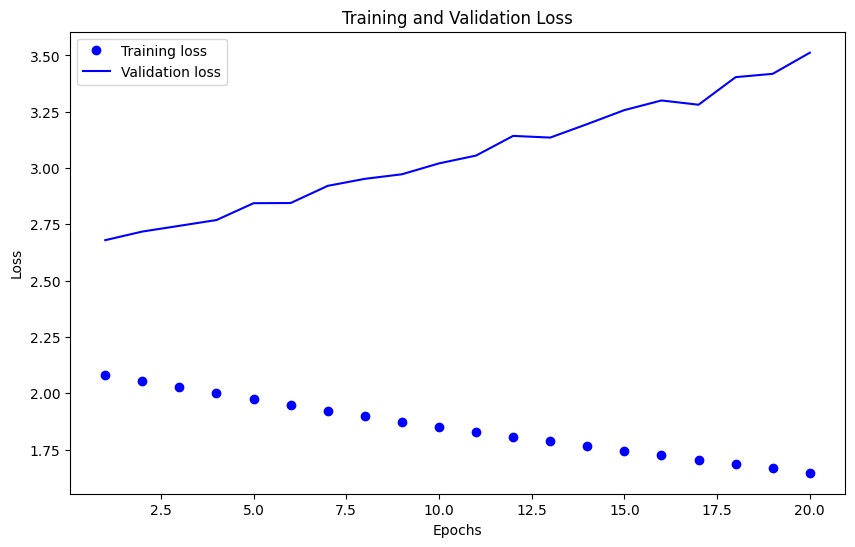

In [33]:
import matplotlib.pyplot as plt

# Obtiene los valores de pérdida de entrenamiento y validación del objeto history
loss = history.history['loss']
val_loss = history_dict['val_loss']
epochs = range(1, len(loss) + 1)  

# Crea una gráfica de líneas para la pérdida de entrenamiento y validación
plt.figure(figsize=(10, 6))  
plt.plot(epochs, loss, 'bo', label='Training loss')  
plt.plot(epochs, val_loss, 'b', label='Validation loss')  
plt.title('Training and Validation Loss')  
plt.xlabel('Epochs')  
plt.ylabel('Loss') 
plt.legend()  

plt.show()  


Gráfico de Loss:
+ Pérdida de Entrenamiento: Comienza alta y disminuye rápidamente, lo cual es un buen indicador de que el modelo está aprendiendo de los datos de entrenamiento.
+ Pérdida de Validación: Empieza más baja que la pérdida de entrenamiento y aumenta a medida que avanzan las épocas, lo que sugiere que el modelo podría estar sobreajustando los datos de entrenamiento.

Esta tendencia creciente en la pérdida de validación mientras la pérdida de entrenamiento sigue disminuyendo indica un claro sobreajuste. El modelo está aprendiendo patrones específicos del conjunto de entrenamiento que no se generalizan bien al conjunto de validación.

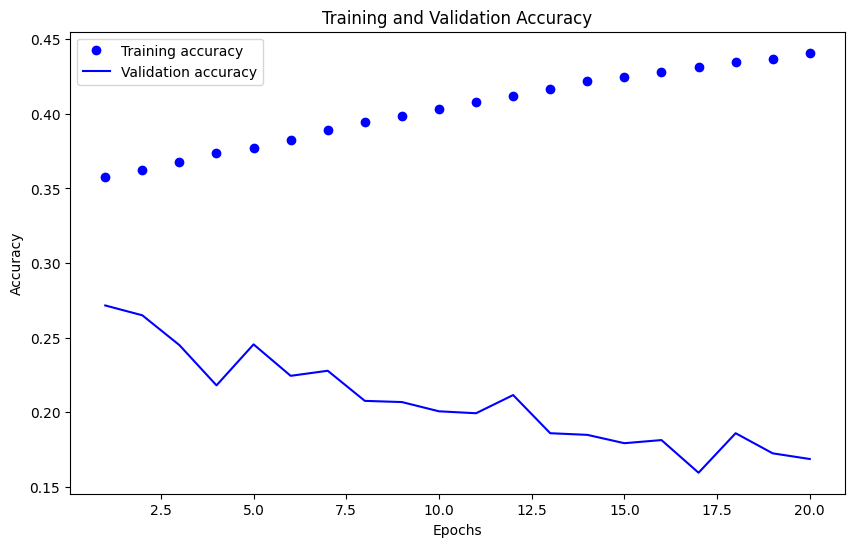

In [34]:
import matplotlib.pyplot as plt

# Obtiene los valores de pérdida de entrenamiento y validación del objeto history
acc = history.history['accuracy']
val_acc = history_dict['val_accuracy']
epochs = range(1, len(loss) + 1)  

# Crea una gráfica de líneas para la pérdida de entrenamiento y validación
plt.figure(figsize=(10, 6))  
plt.plot(epochs, acc, 'bo', label='Training accuracy')  
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')  
plt.title('Training and Validation Accuracy')  
plt.xlabel('Epochs') 
plt.ylabel('Accuracy')  
plt.legend() 

plt.show()  


Gráfico de Accuracy:
+ Precisión de Entrenamiento: Aumenta de manera constante a lo largo de las épocas, lo cual es un signo positivo que indica que el modelo se está volviendo más preciso en el conjunto de entrenamiento.
+ Precisión de Validación: Es bastante fluctuante y generalmente decreciente, lo cual es preocupante. El modelo no solo no está mejorando su rendimiento en el conjunto de validación, sino que también parece estar perdiendo la capacidad de generalizar a datos no vistos.

In [35]:
results = model.evaluate(x_test, y_test)

673/673 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.1815 - loss: 3.4535


In [39]:
print(f'Test loss: {results[0]}')
print(f'Test accuracy: {results[1]}')

Test loss: 3.487191915512085
Test accuracy: 0.17726047337055206


Vamos a intentar mejorar el modelo

In [38]:
from keras import models, regularizers
from keras import layers

model = models.Sequential()
# Capa de Embedding
model.add(layers.Embedding(input_dim=10000, output_dim=100, input_length=200))
# Opción: Agregar Dropout después del embedding
model.add(layers.Dropout(0.5))

# Puedes intentar una capa convolucional 1D aquí para capturar relaciones espaciales
model.add(layers.Conv1D(32, 5, activation='relu'))
model.add(layers.MaxPooling1D(5))

# Opción: Agregar capas recurrentes como GRU o LSTM
model.add(layers.GRU(32, dropout=0.2, recurrent_dropout=0.2))

# Capa Flatten no necesaria si terminas con capas recurrentes
# Añadir regularización a las capas densas
model.add(layers.Dense(16, kernel_regularizer=regularizers.l2(0.001), activation='relu'))
model.add(layers.Dropout(0.5))  # Agregar Dropout
model.add(layers.Dense(16, kernel_regularizer=regularizers.l2(0.001), activation='relu'))
model.add(layers.Dropout(0.5))  # Agregar Dropout

# Capa de Salida
model.add(layers.Dense(23, activation='softmax'))  

# Compilación del modelo
model.compile(optimizer='adam',  # Puedes intentar con 'adam' que generalmente funciona bien
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Ahora el modelo está listo para ser entrenado


/Users/blanca/.pyenv/versions/3.9.18/envs/myenv/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [40]:
history2 = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))


Epoch 1/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 81s 499ms/step - accuracy: 0.1669 - loss: 3.0702 - val_accuracy: 0.2608 - val_loss: 2.8825
Epoch 2/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 79s 529ms/step - accuracy: 0.2661 - loss: 2.8645 - val_accuracy: 0.2608 - val_loss: 2.8085
Epoch 3/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 79s 531ms/step - accuracy: 0.2723 - loss: 2.8181 - val_accuracy: 0.2608 - val_loss: 2.7930
Epoch 4/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 79s 532ms/step - accuracy: 0.2672 - loss: 2.8040 - val_accuracy: 0.2608 - val_loss: 2.7869
Epoch 5/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 76s 513ms/step - accuracy: 0.2709 - loss: 2.7932 - val_accuracy: 0.2608 - val_loss: 2.7853
Epoch 6/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 82s 545ms/step - accuracy: 0.2722 - loss: 2.7819 - val_accuracy: 0.2608 - val_loss: 2.7839
Epoch 7/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 81s 546ms/step - accuracy: 0.2716 - loss: 2.7813 - val_accuracy: 0.2608 - val_loss: 2.7831
Epoch 8/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 78s 519ms/step - accuracy: 0.2704 - loss: 2

In [41]:
results = model.evaluate(x_test, y_test)
print(f'Test loss: {results[0]}')
print(f'Test accuracy: {results[1]}')

673/673 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - accuracy: 0.2717 - loss: 2.7574
Test loss: 2.761162281036377
Test accuracy: 0.26953813433647156


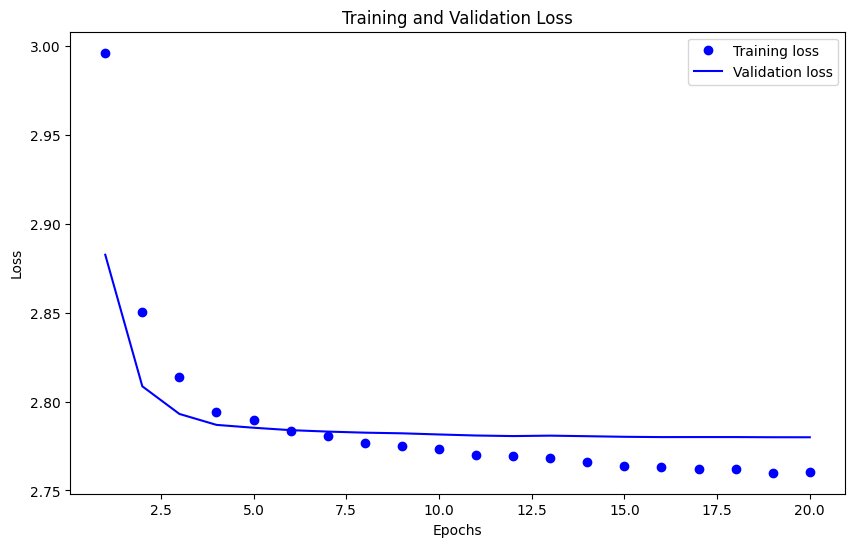

In [42]:
import matplotlib.pyplot as plt

# Obtiene los valores de pérdida de entrenamiento y validación del objeto history
loss = history2.history['loss']
val_loss = history2.history['val_loss']
epochs = range(1, len(loss) + 1)  

# Crea una gráfica de líneas para la pérdida de entrenamiento y validación
plt.figure(figsize=(10, 6))  
plt.plot(epochs, loss, 'bo', label='Training loss')  
plt.plot(epochs, val_loss, 'b', label='Validation loss')  
plt.title('Training and Validation Loss')  
plt.xlabel('Epochs')  
plt.ylabel('Loss') 
plt.legend()  

plt.show()  


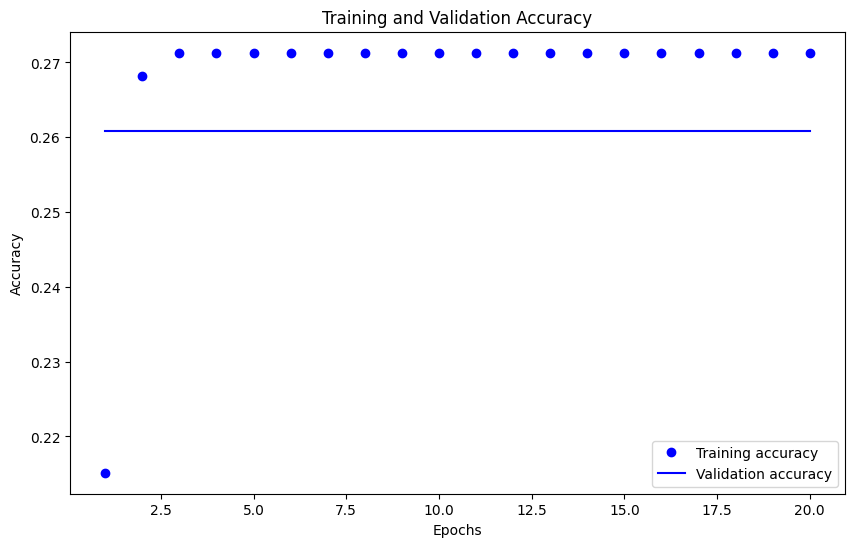

In [44]:
import matplotlib.pyplot as plt

# Obtiene los valores de pérdida de entrenamiento y validación del objeto history
acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']
epochs = range(1, len(loss) + 1)  

# Crea una gráfica de líneas para la pérdida de entrenamiento y validación
plt.figure(figsize=(10, 6))  
plt.plot(epochs, acc, 'bo', label='Training accuracy')  
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')  
plt.title('Training and Validation Accuracy')  
plt.xlabel('Epochs') 
plt.ylabel('Accuracy')  
plt.legend() 

plt.show()  


# Predicciones

In [45]:
# predicciones
predictions = model.predict(x_test)
predictions[0]

673/673 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step


array([0.05890038, 0.03425798, 0.034449  , 0.06078972, 0.0773718 ,
       0.02502671, 0.03425768, 0.03495389, 0.01629002, 0.03641732,
       0.05412265, 0.02166883, 0.01168905, 0.02155927, 0.01232615,
       0.03282904, 0.02951132, 0.02618054, 0.2584244 , 0.03182459,
       0.03733313, 0.02663969, 0.02317685], dtype=float32)